## Phương pháp lai hóa: Loại bỏ đặc trưng bằng đệ quy

Phương pháp này gồm các bước sau:

1) Xếp hạng các đặc trưng theo mức độ quan trọng của chúng từ thuật toán học máy: có thể là mức độ quan trọng của cây hoặc các hệ số thu được từ mô hình tuyến tính.

2) Loại bỏ đặc trưng ít quan trọng nhất và xây dựng thuật toán học máy bằng với các đặc trưng còn lại.

3) Tính toán phép đo chất lượng được lựa chọn: roc-auc, mse, rmse, accuracy,...

4) Nếu phép đo giảm nhiều hơn ngưỡng được thiết lập tùy ý thì đặc trưng đó quan trọng và cần được giữ lại; nếu không, chúng ta có thể loại bỏ đặc trưng đó.

5) Lặp lại các bước 2-4 cho đến khi tất cả các đặc trưng đã được đánh giá.


Phương pháp này được gọi là phương pháp lai hóa vì:

- nó lấy mức độ quan trọng từ thuật toán học máy như các phương pháp nhúng
- nó xây dựng một số mô hình học máy như các phương pháp gói.

Phương pháp này nhanh hơn các phương pháp gói và thường tốt hơn các phương pháp nhúng. Trên thực tế, nó hoạt động cực kỳ hiệu quả.

Cần lưu ý là mức giảm chất lượng tối thiểu để quyết định xem có nên giữ lại một đặc trưng hay không được thiết lập tùy ý. Mức giảm càng nhỏ thì càng có nhiều đặc trưng được chọn và ngược lại.


Chúng ta sẽ trình bày cách lựa chọn đặc trưng bằng phương pháp lai hóa trong bài toán hồi quy và phân loại. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Hồi quy

In [2]:
# load tập dữ liệu

data = pd.read_csv('./datatset/house-price/houseprice.csv')
data.shape

(1460, 81)

In [3]:
# Trên thực tế, nên thực hiện lựa chọn đặc trưng sau khi tiền xử lý dữ liệu,
# tất cả các biến hạng mục được mà hóa thành số,
# và rồi chúng ta có thể đánh giá tính tất định của các mục tiêu

# để đơn giản, chúng ta sẽ chỉ sử dụng biến dạng số
# lựa chọn các cột số:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [4]:
# chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [5]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Xây dựng mô hình học máy với tất cả các đặc trưng

In [6]:
# bước đầu tiên của quy trình này gồm xây dựng
# một thuật toán học máy với tất cả các đặc trưng
# rồi xác định mức độ quan trọng của các đặc trưng theo
# thuật toán

# xây dựng mô hình đầu tiên với tất cả các đặc trưng
model_full = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# tính r2 trong tập kiểm tra
y_pred_test = model_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)

print('Test full dataset R2 = %f' % (r2_full))

Test full dataset R2 = 0.713130


### Xếp hạng các đặc trưng theo mức độ quan trọng

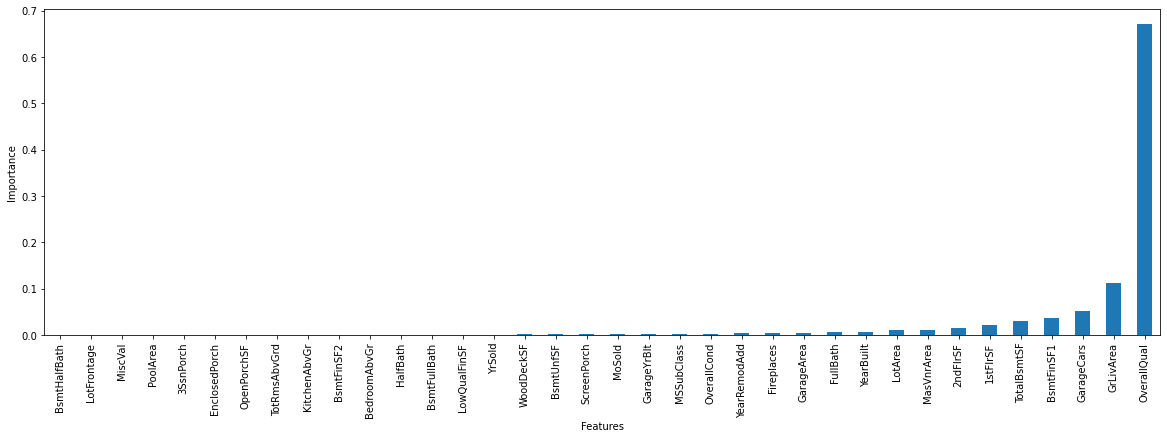

In [7]:
# bước thứ hai là lấy mức độ quan trọng của
# từng đặc trưng và xếp hạng từ ít quan trọng nhất đến 
# quan trọng nhất

# lấy tên đặc trưng và mức độ quan trọng
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sắp xếp đặc trưng theo mức độ quan trọng
features.sort_values(ascending=True, inplace=True)

# vẽ biểu đồ
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [8]:
# tạo một list với các đặc trưng đã sắp xếp
features = list(features.index)
features

['BsmtHalfBath',
 'LotFrontage',
 'MiscVal',
 'PoolArea',
 '3SsnPorch',
 'EnclosedPorch',
 'OpenPorchSF',
 'TotRmsAbvGrd',
 'KitchenAbvGr',
 'BsmtFinSF2',
 'BedroomAbvGr',
 'HalfBath',
 'BsmtFullBath',
 'LowQualFinSF',
 'YrSold',
 'WoodDeckSF',
 'BsmtUnfSF',
 'ScreenPorch',
 'MoSold',
 'GarageYrBlt',
 'MSSubClass',
 'OverallCond',
 'YearRemodAdd',
 'Fireplaces',
 'GarageArea',
 'FullBath',
 'YearBuilt',
 'LotArea',
 'MasVnrArea',
 '2ndFlrSF',
 '1stFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'GarageCars',
 'GrLivArea',
 'OverallQual']

### Lựa chọn đặc trưng

In [9]:
# bước cuối cùng là loại bỏ từng
# đặc trưng, từ ít quan trọng nhất tới
# quan trọng nhất và xây dựng mô hình ở mỗi vòng.

# khi đã tạo mô hình, chúng ta tính r2 mới 
# nếu r2 mới nhỏ hơn r2 ban đầu
# (với tất cả các đặc trưng) đặc trưng bị loại bỏ đó
# nếu quan trọng thì giữ lại
# nếu không thì loại bỏ đặc trưng

# loại bỏ đặc trưng bằng đệ quy:

# trước tiên thiết lập mức giảm tùy ý trong r2
# nếu mức giảm thấp hơn ngưỡng này,
# thì đặc trưng sẽ bị loại bỏ
tol = 0.001

print('doing recursive feature elimination')

# khởi tạo một list để thu thập
# các đặc trưng sẽ loại bỏ
features_to_remove = []

# thiết lập bộ đếm để biết đặc trưng nào đang được đánh giá
count = 1

# lặp qua tất cả các đặc trưng, theo thứ tự mức độ quan trọng:
# các đặc trưng trong list đã được sắp xếp
# theo mức độ quan trọng
for feature in features:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # khởi tạo mô hình
    model_int = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

    # khớp mô hình với tất cả các biến trừ đi các đặc trưng đã bị loại
    # và đặc trưng được đánh giá
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # đưa ra dự đoán trên tập kiểm tra
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # tính r2 mới
    r2_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_int)))

    # in ra r2 ban đầu với tất cả các đặc trưng
    print('All features Test r2 = {}'.format((r2_full)))

    # xác định mức giảm trong r2
    diff_r2 = r2_full - r2_int

    # so sánh mức giảm trong r2 với dung sai
    # chúng ta đã thiết lập trước đó
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # nếu mức giảm trong r2 nhỏ và chúng ta loại
        # đặc trưng, cần thiết lập r2 mới dựa trên
        # các đặc trưng còn lại
        r2_full = r2_int
        
        # và thêm đặc trưng loại bỏ vào list thu thập
        features_to_remove.append(feature)

# vòng lặp đã hoàn thành, chúng ta đánh giá mọi đặc trưng
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# xác định các đặc trưng cần giữ (các đặc trưng không bị loại)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  BsmtHalfBath 1  out of  36
New Test r2 = 0.7273575444777846
All features Test r2 = 0.7131302556471364
Drop in r2 = -0.014227288830648166
remove:  BsmtHalfBath

testing feature:  LotFrontage 2  out of  36
New Test r2 = 0.718688691614447
All features Test r2 = 0.7273575444777846
Drop in r2 =0.008668852863337517
keep:  LotFrontage

testing feature:  MiscVal 3  out of  36
New Test r2 = 0.7134932811944362
All features Test r2 = 0.7273575444777846
Drop in r2 =0.013864263283348333
keep:  MiscVal

testing feature:  PoolArea 4  out of  36
New Test r2 = 0.7122308203172486
All features Test r2 = 0.7273575444777846
Drop in r2 =0.015126724160535954
keep:  PoolArea

testing feature:  3SsnPorch 5  out of  36
New Test r2 = 0.7208667083658631
All features Test r2 = 0.7273575444777846
Drop in r2 =0.006490836111921472
keep:  3SsnPorch

testing feature:  EnclosedPorch 6  out of  36
New Test r2 = 0.7173229445184786
All features Test r2 = 0.727357544477

In [10]:
# cuối cùng, kiểm tra chất lượng của mô hình
# xây dựng trên các đặc trưng được chọn

# xây dựng mô hình ban đầu
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# khớp mô hình với các đặc trưng đã chọn
model_final.fit(X_train[features_to_keep], y_train)

# đưa ra dự đoán
y_pred_test = model_final.predict(X_test[features_to_keep])

# tính roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.732437


Mô hình được tạo có 28 đặc trưng thể hiện chất lượng tương tự hoặc tốt hơn một chút! (cần kéo xuống để tìm giá trị này, chúng ta đã tính trong một số cell trước)